In [1]:
include("D:\\Julia\\dqmc_fsj\\lattice_model.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_parameters.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_fields.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_matrix_cdw_channel.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_stable.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_eqlt_greens.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_update.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_helper.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_ueqlt_greens.jl")

using LoopVectorization

In [15]:
# L = 8 case
betas = (2.0, 5.0, 6.0, 7.0)
# mus = vcat(-2.0, -1.5, -1.25:0.05:-1.0, -0.8:0.2:0.8, 0.9:0.05:1.25, 1.5, 2.0)  # for L = 4
mus = vcat(-2.0:0.5:-0.5, -0.1:0.1:1.1,1.25, 1.5, 2.0)

Lx = 8
Ly = 8
t = 1.0
Hubbard_U = 4.0

thermal_sweeps = 1000
meas_sweeps = 1000

tri_lat = Triangular_Lattice(Lx, Ly)

occs_av_meas = zeros(Float64, (length(betas), length(mus)))
occs_av_errors = zeros(Float64, (length(betas), length(mus)))

pc_q0_meas = zeros(Float64, (length(betas), length(mus)))
pc_q0_errors = zeros(Float64, (length(betas), length(mus)))

4×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
@time for (beta_index, beta) in enumerate(betas), (mu_index, mu) in enumerate(mus)
#     println(beta_index, mu_index)
    tri_model = Single_Band_Hubbard_Model(t=t, U=Hubbard_U, mu=mu, lattice=tri_lat)
    parameters = dqmc_parameters(beta=beta)
    hs_field = HSField_CDW(delta_tau=parameters.delta_tau, slice_num=parameters.slices, 
        n_sites=tri_model.lattice.sites, U=tri_model.Hubbard_U)
    stack = dqmc_matrices_stack_real_qr(tri_model, parameters)

    build_udt_stacks_modified!(hs_field, stack)
    copyto!(stack.u_stack[1], I)
    stack.d_stack[1] .= one(Float64)
    copyto!(stack.t_stack[1], I)

    # 热化
    thermalization_sweeps(hs_field, stack, thermal_sweeps)
    
    # 测量
    dims = stack.dims
    bins_occs = zeros(Float64, (dims, meas_sweeps))
    bins_pc_q0 = zeros(Float64, meas_sweeps)
    for sweep_idx in 1:meas_sweeps
        sweep_up_local_modified!(hs_field, stack)
        sweep_down_local_modified!(hs_field, stack)
        
        # 先计算平均占据数
        stack.current_range = 1
        get_greens_temp_modified!(stack)
        for site = 1:dims
            bins_occs[site, sweep_idx] = 2 * (1 - stack.greens_temp[site,site]) # 2来自于自旋简并
        end
        
        # 再计算pairing correlation
        for site1 in 1:dims
            for site2 in 1:dims
                bins_pc_q0[sweep_idx] += 2 * (stack.greens_temp[site1, site2])^2
            end
        end
        
#         for site in 1:dims
#             bins_pc_q0[sweep_idx] += (1 - 2 * stack.greens_temp[site,site])
#         end
    end
    
    occs_av = sum(bins_occs) / (meas_sweeps * dims)
    occs_av_meas[beta_index, mu_index] = occs_av 
    
    occs_av_error = Float64(0.0)
    @turbo for sweep_idx in 1:meas_sweeps
        for site in 1:dims
            occs_av_error += (bins_occs[site, sweep_idx] - occs_av) ^ 2
        end
    end
    occs_av_error = occs_av_error / (dims ^ 2)
    occs_av_error = occs_av_error / sqrt((meas_sweeps - 1) * meas_sweeps)
    occs_av_errors[beta_index, mu_index] = occs_av_error
    
    
    pc_q0 = sum(bins_pc_q0) / (meas_sweeps)
    pc_q0_meas[beta_index, mu_index] = pc_q0 / (2 * dims)  # 还要除以2，为了与文章对齐
    
    pc_q0_error = Float64(0.0)
    @turbo for sweep_idx in 1:meas_sweeps
        pc_q0_error += (bins_pc_q0[sweep_idx] - pc_q0) ^ 2
    end
    pc_q0_error = pc_q0_error / (dims ^ 2)
    pc_q0_error = pc_q0_error / sqrt((meas_sweeps - 1) * meas_sweeps)
    pc_q0_errors[beta_index, mu_index] = pc_q0_error
    
#     println("finished!")
end

881.188464 seconds (2.00 G allocations: 35.052 GiB, 0.46% gc time)


In [19]:
using CairoMakie, FileIO, Colors

fig = Figure(resolution = (800, 800))
top = Axis(fig[1, 1])
bot = Axis(fig[2, 1])

c = HSV(250, 0.6, 1)

# band!(top, mus, occs_av_meas[1,:] .- occs_av_errors[1,:], occs_av_meas[1,:] .+ occs_av_errors[1,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[1,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[1,:], color = c, marker = ('■', '□', 'o')[1])

# band!(top, mus, occs_av_meas[2,:] .- occs_av_errors[2,:], occs_av_meas[2,:] .+ occs_av_errors[2,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[2,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[2,:], color = c, marker = ('■', '□', 'o')[2])

# band!(top, mus, occs_av_meas[3,:] .- occs_av_errors[3,:], occs_av_meas[3,:] .+ occs_av_errors[3,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[3,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[3,:], color = c, marker = ('■', '□', 'o')[3])

for beta_index in 1:length(betas)
    band!(top, mus, occs_av_meas[beta_index,:] - occs_av_errors[beta_index,:], occs_av_meas[beta_index,:] + occs_av_errors[beta_index,:], color = (:red, 0.3), transparency=true)
    lines!(top, mus, occs_av_meas[beta_index,:], color = (c, 0.5), linewidth=2)
    scatter!(top, mus, occs_av_meas[beta_index,:], color = c, marker = ('■', '□', '◬', 'o')[beta_index])
    
#     band!(bot, mus, pc_q0_meas[beta_index,:] - pc_q0_errors[beta_index,:], pc_q0_meas[beta_index,:] + pc_q0_errors[beta_index,:], color = (:red, 0.3), transparency=true)
    lines!(bot, mus, pc_q0_meas[beta_index,:], color = (c, 0.5), linewidth=2)
    scatter!(bot, mus, pc_q0_meas[beta_index,:], color = c, marker = ('■', '□', '◬', 'o')[beta_index])
end

axislegend(top, top.scene.plots[4:3:end], ["β = 2", "β = 5", "β = 6", "β = 7"], position = :rb)
xlims!(top, -2 , 2)
ylims!(top, 0 , 2)
xlims!(bot, -2 , 2)
ylims!(bot, 0 , 6.5) # for L = 8
# ylims!(bot, 0 , 3.5) # for L = 6
# ylims!(bot, 0 , 2.5)  # for L = 4

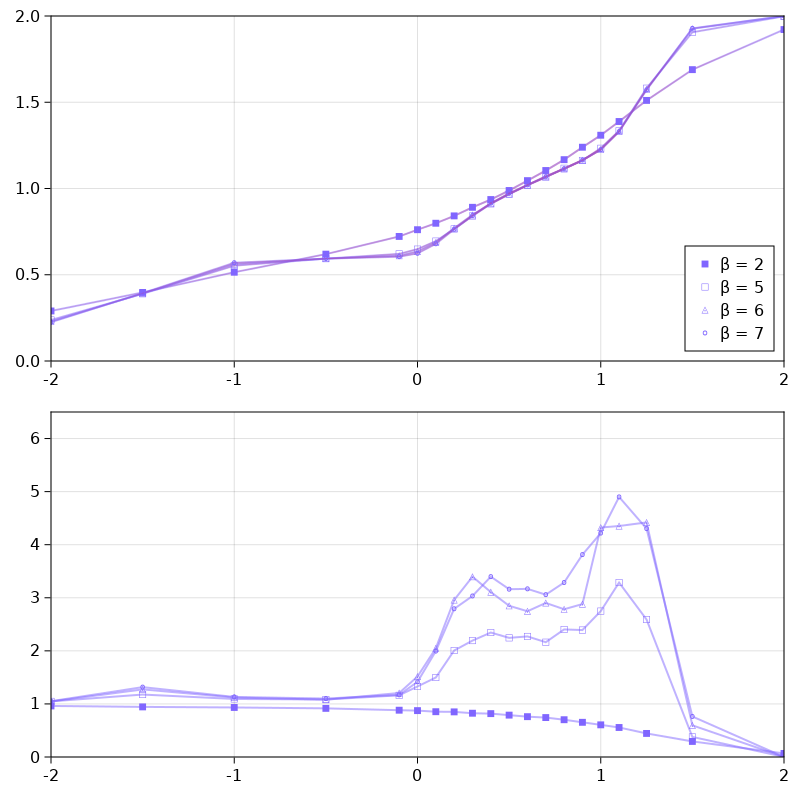

In [20]:
current_figure()

In [21]:
# L = 6 case
betas = (2.0, 5.0, 6.0, 7.0)
mus = vcat(-2.0:0.25:-0.25, -0.1:0.1:1.1,1.25, 1.5, 2.0)

Lx = 6
Ly = 6
t = 1.0
Hubbard_U = 4.0

thermal_sweeps = 1000
meas_sweeps = 1000

tri_lat = Triangular_Lattice(Lx, Ly)

occs_av_meas = zeros(Float64, (length(betas), length(mus)))
occs_av_errors = zeros(Float64, (length(betas), length(mus)))

pc_q0_meas = zeros(Float64, (length(betas), length(mus)))
pc_q0_errors = zeros(Float64, (length(betas), length(mus)))

4×24 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [22]:
@time for (beta_index, beta) in enumerate(betas), (mu_index, mu) in enumerate(mus)
#     println(beta_index, mu_index)
    tri_model = Single_Band_Hubbard_Model(t=t, U=Hubbard_U, mu=mu, lattice=tri_lat)
    parameters = dqmc_parameters(beta=beta)
    hs_field = HSField_CDW(delta_tau=parameters.delta_tau, slice_num=parameters.slices, 
        n_sites=tri_model.lattice.sites, U=tri_model.Hubbard_U)
    stack = dqmc_matrices_stack_real_qr(tri_model, parameters)

    build_udt_stacks_modified!(hs_field, stack)
    copyto!(stack.u_stack[1], I)
    stack.d_stack[1] .= one(Float64)
    copyto!(stack.t_stack[1], I)

    # 热化
    thermalization_sweeps(hs_field, stack, thermal_sweeps)
    
    # 测量
    dims = stack.dims
    bins_occs = zeros(Float64, (dims, meas_sweeps))
    bins_pc_q0 = zeros(Float64, meas_sweeps)
    for sweep_idx in 1:meas_sweeps
        sweep_up_local_modified!(hs_field, stack)
        sweep_down_local_modified!(hs_field, stack)
        
        # 先计算平均占据数
        stack.current_range = 1
        get_greens_temp_modified!(stack)
        for site = 1:dims
            bins_occs[site, sweep_idx] = 2 * (1 - stack.greens_temp[site,site]) # 2来自于自旋简并
        end
        
        # 再计算pairing correlation
        for site1 in 1:dims
            for site2 in 1:dims
                bins_pc_q0[sweep_idx] += 2 * (stack.greens_temp[site1, site2])^2
            end
        end
        
#         for site in 1:dims
#             bins_pc_q0[sweep_idx] += (1 - 2 * stack.greens_temp[site,site])
#         end
    end
    
    occs_av = sum(bins_occs) / (meas_sweeps * dims)
    occs_av_meas[beta_index, mu_index] = occs_av 
    
    occs_av_error = Float64(0.0)
    @turbo for sweep_idx in 1:meas_sweeps
        for site in 1:dims
            occs_av_error += (bins_occs[site, sweep_idx] - occs_av) ^ 2
        end
    end
    occs_av_error = occs_av_error / (dims ^ 2)
    occs_av_error = occs_av_error / sqrt((meas_sweeps - 1) * meas_sweeps)
    occs_av_errors[beta_index, mu_index] = occs_av_error
    
    
    pc_q0 = sum(bins_pc_q0) / (meas_sweeps)
    pc_q0_meas[beta_index, mu_index] = pc_q0 / (2 * dims)  # 还要除以2，为了与文章对齐
    
    pc_q0_error = Float64(0.0)
    @turbo for sweep_idx in 1:meas_sweeps
        pc_q0_error += (bins_pc_q0[sweep_idx] - pc_q0) ^ 2
    end
    pc_q0_error = pc_q0_error / (dims ^ 2)
    pc_q0_error = pc_q0_error / sqrt((meas_sweeps - 1) * meas_sweeps)
    pc_q0_errors[beta_index, mu_index] = pc_q0_error
    
#     println("finished!")
end

274.151673 seconds (767.64 M allocations: 13.533 GiB, 0.56% gc time)


In [25]:
using CairoMakie, FileIO, Colors

fig = Figure(resolution = (800, 800))
top = Axis(fig[1, 1])
bot = Axis(fig[2, 1])

c = HSV(250, 0.6, 1)

# band!(top, mus, occs_av_meas[1,:] .- occs_av_errors[1,:], occs_av_meas[1,:] .+ occs_av_errors[1,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[1,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[1,:], color = c, marker = ('■', '□', 'o')[1])

# band!(top, mus, occs_av_meas[2,:] .- occs_av_errors[2,:], occs_av_meas[2,:] .+ occs_av_errors[2,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[2,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[2,:], color = c, marker = ('■', '□', 'o')[2])

# band!(top, mus, occs_av_meas[3,:] .- occs_av_errors[3,:], occs_av_meas[3,:] .+ occs_av_errors[3,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[3,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[3,:], color = c, marker = ('■', '□', 'o')[3])

for beta_index in 1:length(betas)
    band!(top, mus, occs_av_meas[beta_index,:] - occs_av_errors[beta_index,:], occs_av_meas[beta_index,:] + occs_av_errors[beta_index,:], color = (:red, 0.3), transparency=true)
    lines!(top, mus, occs_av_meas[beta_index,:], color = (c, 0.5), linewidth=2)
    scatter!(top, mus, occs_av_meas[beta_index,:], color = c, marker = ('■', '□', '◬', 'o')[beta_index])
    
#     band!(bot, mus, pc_q0_meas[beta_index,:] - pc_q0_errors[beta_index,:], pc_q0_meas[beta_index,:] + pc_q0_errors[beta_index,:], color = (:red, 0.3), transparency=true)
    lines!(bot, mus, pc_q0_meas[beta_index,:], color = (c, 0.5), linewidth=2)
    scatter!(bot, mus, pc_q0_meas[beta_index,:], color = c, marker = ('■', '□', '◬', 'o')[beta_index])
end

axislegend(top, top.scene.plots[4:3:end], ["β = 2", "β = 5", "β = 6", "β = 7"], position = :rb)
xlims!(top, -2 , 2)
ylims!(top, 0 , 2)
xlims!(bot, -2 , 2)
ylims!(bot, 0 , 3.5) # for L = 6

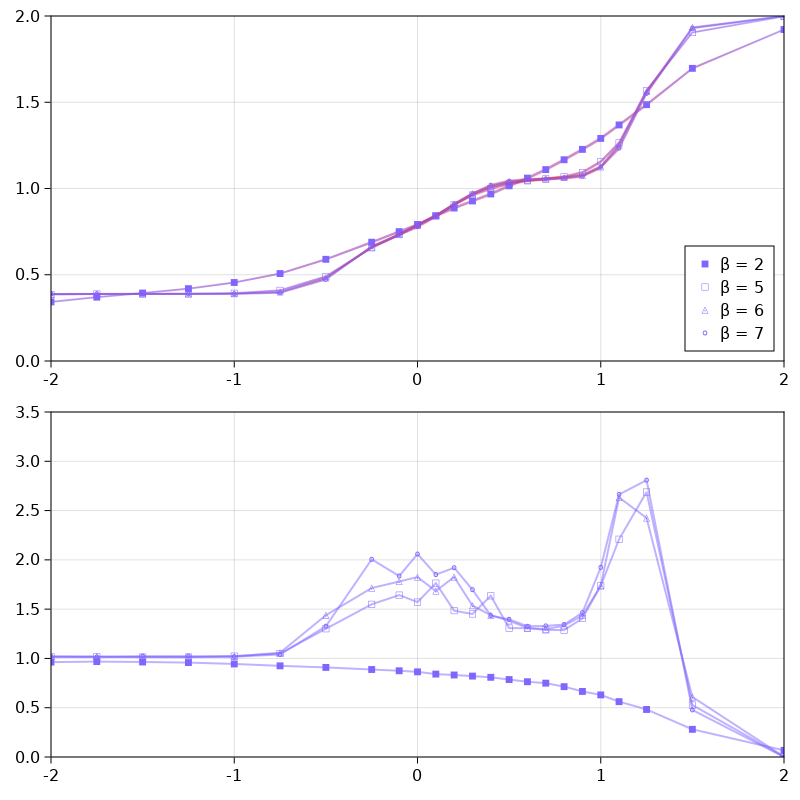

In [26]:
current_figure()

In [2]:
# L = 4 case
betas = (2.0, 5.0, 6.0, 7.0)
mus = vcat(-2.0, -1.5, -1.25:0.05:-1.0, -0.8:0.2:0.8, 0.9:0.05:1.25, 1.5, 2.0)  # for L = 4

Lx = 4
Ly = 4
t = 1.0
Hubbard_U = 4.0

thermal_sweeps = 1000
meas_sweeps = 1000

tri_lat = Triangular_Lattice(Lx, Ly)

occs_av_meas = zeros(Float64, (length(betas), length(mus)))
occs_av_errors = zeros(Float64, (length(betas), length(mus)))

pc_q0_meas = zeros(Float64, (length(betas), length(mus)))
pc_q0_errors = zeros(Float64, (length(betas), length(mus)))

4×27 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [12]:
@time for (beta_index, beta) in enumerate(betas), (mu_index, mu) in enumerate(mus)
#     println(beta_index, mu_index)
    tri_model = Single_Band_Hubbard_Model(t=t, U=Hubbard_U, mu=mu, lattice=tri_lat)
    parameters = dqmc_parameters(beta=beta)
    hs_field = HSField_CDW(delta_tau=parameters.delta_tau, slice_num=parameters.slices, 
        n_sites=tri_model.lattice.sites, U=tri_model.Hubbard_U)
    stack = dqmc_matrices_stack_real_qr(tri_model, parameters)

    build_udt_stacks_modified!(hs_field, stack)
    copyto!(stack.u_stack[1], I)
    stack.d_stack[1] .= one(Float64)
    copyto!(stack.t_stack[1], I)

    # 热化
    thermalization_sweeps(hs_field, stack, thermal_sweeps)
    
    # 测量
    dims = stack.dims
    bins_occs = zeros(Float64, (dims, meas_sweeps))
    bins_pc_q0 = zeros(Float64, meas_sweeps)
    for sweep_idx in 1:meas_sweeps
        sweep_up_local_modified!(hs_field, stack)
        sweep_down_local_modified!(hs_field, stack)
        
        # 先计算平均占据数
        stack.current_range = 1
        get_greens_temp_modified!(stack)
        for site = 1:dims
            bins_occs[site, sweep_idx] = 2 * (1 - stack.greens_temp[site,site]) # 2来自于自旋简并
        end
        
        # 再计算pairing correlation
        for site1 in 1:dims
            for site2 in 1:dims
                bins_pc_q0[sweep_idx] += 2 * (stack.greens_temp[site1, site2])^2
            end
        end
        
#         for site in 1:dims
#             bins_pc_q0[sweep_idx] += (1 - 2 * stack.greens_temp[site,site])
#         end
    end
    
    occs_av = sum(bins_occs) / (meas_sweeps * dims)
    occs_av_meas[beta_index, mu_index] = occs_av 
    
    occs_av_error = Float64(0.0)
    @turbo for sweep_idx in 1:meas_sweeps
        for site in 1:dims
            occs_av_error += (bins_occs[site, sweep_idx] - occs_av) ^ 2
        end
    end
    occs_av_error = occs_av_error / (dims ^ 2)
    occs_av_error = occs_av_error / sqrt((meas_sweeps - 1) * meas_sweeps)
    occs_av_errors[beta_index, mu_index] = occs_av_error
    
    
    pc_q0 = sum(bins_pc_q0) / (meas_sweeps)
    pc_q0_meas[beta_index, mu_index] = pc_q0 / (2 * dims)  # 还要除以2，为了与文章对齐
    
    pc_q0_error = Float64(0.0)
    @turbo for sweep_idx in 1:meas_sweeps
        pc_q0_error += (bins_pc_q0[sweep_idx] - pc_q0) ^ 2
    end
    pc_q0_error = pc_q0_error / (dims ^ 2)
    pc_q0_error = pc_q0_error / sqrt((meas_sweeps - 1) * meas_sweeps)
    pc_q0_errors[beta_index, mu_index] = pc_q0_error
    
#     println("finished!")
end

 38.461838 seconds (176.71 M allocations: 3.156 GiB, 1.05% gc time)


In [13]:
using CairoMakie, FileIO, Colors

fig = Figure(resolution = (800, 800))
top = Axis(fig[1, 1])
bot = Axis(fig[2, 1])

c = HSV(250, 0.6, 1)

# band!(top, mus, occs_av_meas[1,:] .- occs_av_errors[1,:], occs_av_meas[1,:] .+ occs_av_errors[1,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[1,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[1,:], color = c, marker = ('■', '□', 'o')[1])

# band!(top, mus, occs_av_meas[2,:] .- occs_av_errors[2,:], occs_av_meas[2,:] .+ occs_av_errors[2,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[2,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[2,:], color = c, marker = ('■', '□', 'o')[2])

# band!(top, mus, occs_av_meas[3,:] .- occs_av_errors[3,:], occs_av_meas[3,:] .+ occs_av_errors[3,:], color = (:red, 0.3), transparency=true)
# lines!(top, mus, occs_av_meas[3,:], color = (c, 0.5), linewidth=2)
# scatter!(top, mus, occs_av_meas[3,:], color = c, marker = ('■', '□', 'o')[3])

for beta_index in 1:length(betas)
    band!(top, mus, occs_av_meas[beta_index,:] - occs_av_errors[beta_index,:], occs_av_meas[beta_index,:] + occs_av_errors[beta_index,:], color = (:red, 0.3), transparency=true)
    lines!(top, mus, occs_av_meas[beta_index,:], color = (c, 0.5), linewidth=2)
    scatter!(top, mus, occs_av_meas[beta_index,:], color = c, marker = ('■', '□', '◬', 'o')[beta_index])
    
#     band!(bot, mus, pc_q0_meas[beta_index,:] - pc_q0_errors[beta_index,:], pc_q0_meas[beta_index,:] + pc_q0_errors[beta_index,:], color = (:red, 0.3), transparency=true)
    lines!(bot, mus, pc_q0_meas[beta_index,:], color = (c, 0.5), linewidth=2)
    scatter!(bot, mus, pc_q0_meas[beta_index,:], color = c, marker = ('■', '□', '◬', 'o')[beta_index])
end

axislegend(top, top.scene.plots[4:3:end], ["β = 2", "β = 5", "β = 6", "β = 7"], position = :rb)
xlims!(top, -2 , 2)
ylims!(top, 0 , 2)
xlims!(bot, -2 , 2)
ylims!(bot, 0 , 2.5) # for L = 6

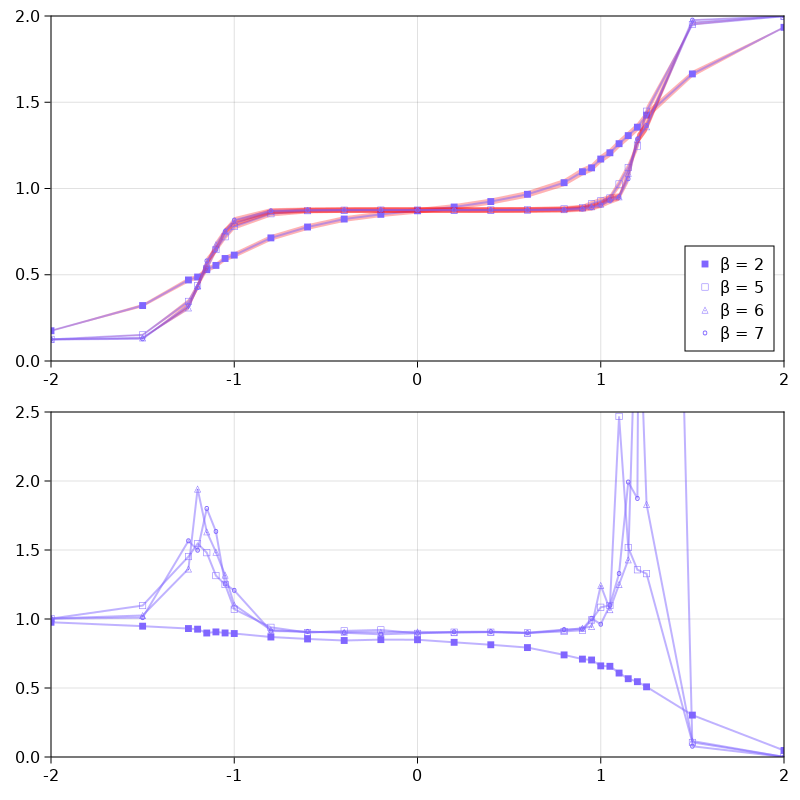

In [14]:
current_figure()